In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os



In [5]:

base_dir = "dataset"  # change if your folder name is different
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # unripe, ripe, overripe, rotten


In [6]:
# --- Cell 3: Data generators with augmentation ---

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 11793 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.
Found 562 images belonging to 4 classes.
Class indices: {'overripe': 0, 'ripe': 1, 'rotten': 2, 'unripe': 3}


In [5]:
# --- Cell 4: Build the ResNet50 model ---

# Load ResNet50 pretrained on ImageNet, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze most layers for transfer learning
for layer in base_model.layers[:-10]:
    layer.trainable = False  # fine-tune only last 10 layers

# Build final model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 33s 4us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 1,061,444 (4.05 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [6]:
# --- Cell 5: Train the model ---

EPOCHS = 15

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


C:\ProgramData\miniconda3\envs\vgg_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.8881 - loss: 0.3070 - val_accuracy: 0.6750 - val_loss: 1.7426
Epoch 2/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9475 - loss: 0.1554 - val_accuracy: 0.7916 - val_loss: 0.9204
Epoch 3/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.9548 - loss: 0.1265 - val_accuracy: 0.8415 - val_loss: 0.6879
Epoch 4/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.9631 - loss: 0.1091 - val_accuracy: 0.8682 - val_loss: 0.4709
Epoch 5/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.9665 - loss: 0.0949 - val_accuracy: 0.9439 - val_loss: 0.1956
Epoch 6/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.9682 - loss: 0.0892 - val_accuracy: 0.9537 - val_loss: 0.1578
Epoch 7/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.9715 - loss: 0.0750 - val_accuracy: 0.9635 - val_loss: 0.1140
Epoch 8/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.9720 - loss: 0.0767 - val_accu

In [7]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 635ms/step - accuracy: 0.9804 - loss: 0.0821
Test Accuracy: 0.9804
Test Loss: 0.0821


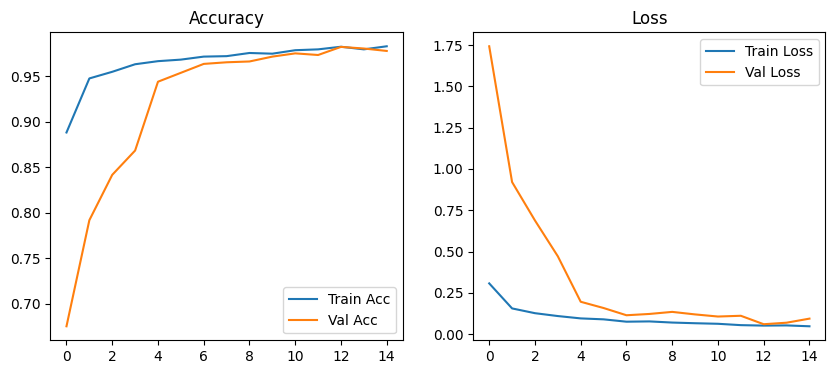

In [8]:
# --- Cell 7: Plot accuracy & loss curves ---

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
model = tf.keras.models.load_model("banana_spoilage_mobilenet.h5")
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=list(train_gen.class_indices.keys())))


C:\ProgramData\miniconda3\envs\vgg_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step
Confusion Matrix
[[112   0   1   0]
 [  1 152   1   0]
 [  4   1 178   2]
 [  1   0   0 109]]
Classification Report
              precision    recall  f1-score   support

    overripe       0.95      0.99      0.97       113
        ripe       0.99      0.99      0.99       154
      rotten       0.99      0.96      0.98       185
      unripe       0.98      0.99      0.99       110

    accuracy                           0.98       562
   macro avg       0.98      0.98      0.98       562
weighted avg       0.98      0.98      0.98       562



## 🧩 Confusion Matrix

| **Actual \ Predicted** | **Overripe** | **Ripe** | **Rotten** | **Unripe** |
|:------------------------|:------------|:---------|:-----------|:-----------|
| **Overripe** | 112 | 0 | 1 | 0 |
| **Ripe** | 1 | 152 | 1 | 0 |
| **Rotten** | 4 | 1 | 178 | 2 |
| **Unripe** | 1 | 0 | 0 | 109 |

In [12]:
model.save("banana_spoilage_mobilenet.h5")

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,709,838 (17.97 MB)

 Trainable params: 1,061,444 (4.05 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

 Optimizer params: 2,122,890 (8.10 MB)

## Classification Report
| Class      | Precision | Recall | F1-Score | Support |
|-------------|------------|---------|-----------|----------|
| Overripe    | 0.95       | 0.99    | 0.97      | 113      |
| Ripe        | 0.99       | 0.99    | 0.99      | 154      |
| Rotten      | 0.99       | 0.96    | 0.98      | 185      |
| Unripe      | 0.98       | 0.99    | 0.99      | 110      |
| **Accuracy** |            |         | **0.98**  | **562**  |
| **Macro Avg** | 0.98     | 0.98    | 0.98      | 562      |
| **Weighted Avg** | 0.98  | 0.98    | 0.98      | 562      |


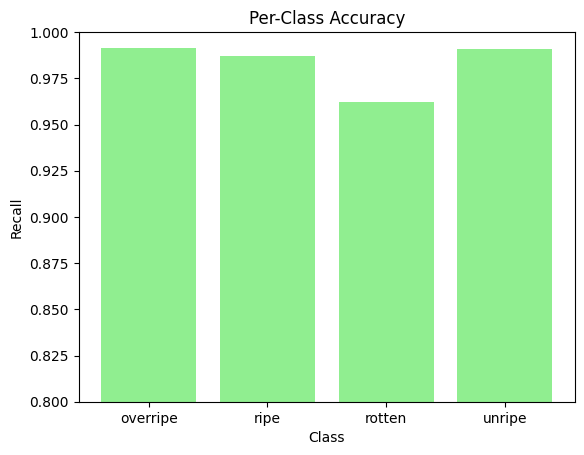

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(test_gen.classes, y_pred, target_names=list(train_gen.class_indices.keys()),output_dict=True)
class_acc = [report[label]['recall'] for label in test_gen.class_indices.keys()]

plt.bar(test_gen.class_indices.keys(), class_acc, color='lightgreen')
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.ylim(0.8, 1.0)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


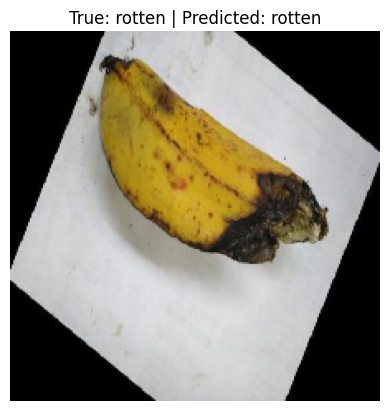

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


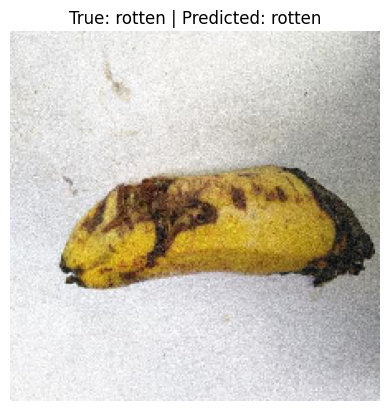

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


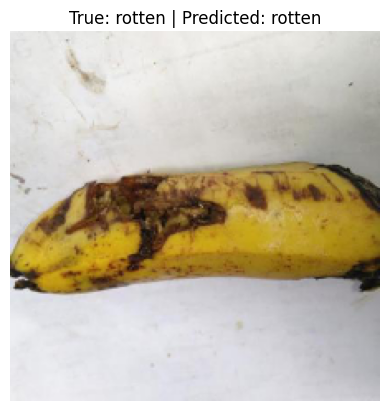

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


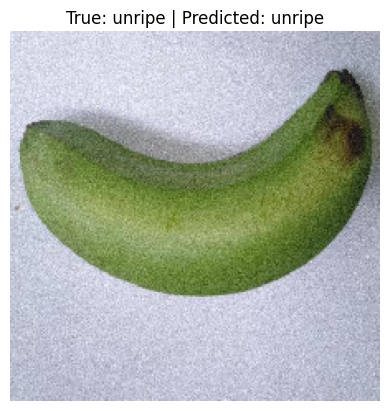

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


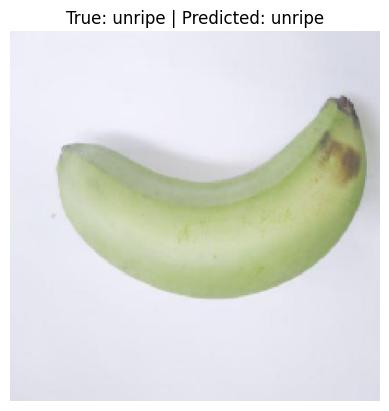

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt

labels = list(test_gen.class_indices.keys())
for i in range(5):
    # Get a random batch
    images, true_labels = next(test_gen)
    
    # Pick a random image from that batch
    i = random.randint(0, len(images) - 1)
    img = images[i]
    true_label = true_labels[i].argmax()
    
    # Predict
    pred = model.predict(img[np.newaxis, ...]).argmax()
    
    plt.imshow(img)
    plt.title(f"True: {labels[true_label]} | Predicted: {labels[pred]}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


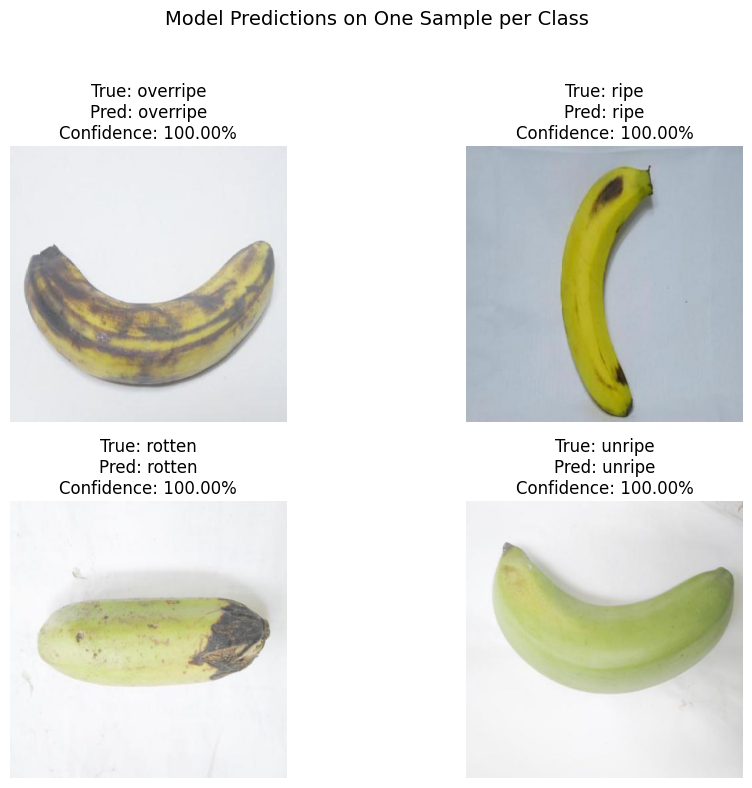

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Get class names from generator
class_names = list(test_gen.class_indices.keys())
test_dir = test_gen.directory

plt.figure(figsize=(10, 8))

for i, cls in enumerate(class_names):
    class_folder = os.path.join(test_dir, cls)
    files = os.listdir(class_folder)
    if not files:
        continue

    img_path = os.path.join(class_folder, np.random.choice(files))

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = float(np.max(preds)) * 100

    plt.subplot(2, 2, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"True: {cls}\nPred: {pred_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")

plt.suptitle("Model Predictions on One Sample per Class", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
